# 0 chargement du dataset

In [1]:
from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']
twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

In [75]:
import pandas as pd
import numpy as np
df_train = pd.DataFrame(data= np.c_[twenty_train['data'], twenty_train['target']],
                     columns= ['text','target'])

# I Data cleaning 

In [77]:
import texthero as hero

In [78]:
df_train['clean_text'] = hero.clean(df_train['text'])

The default pipeline for the clean method is the following:

- fillna(s) Replace not assigned values with empty spaces.
- lowercase(s) Lowercase all text.
- remove_digits() Remove all blocks of digits.
- remove_punctuation() Remove all string.punctuation (!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~).
- remove_diacritics() Remove all accents from strings.
- remove_stopwords() Remove all stop words.
- remove_whitespace() Remove all white space between words.

# II Représentation (modèle de fréquence) 

In [34]:
df_train['tfidf_clean_text'] = hero.tfidf(df_train['clean_text'])

# III visualisations

In [35]:
df_train['pca_tfidf_clean_text'] = hero.pca(df_train['tfidf_clean_text'])

In [81]:
# il y a un problème de type dans ma base de données, pour obtenir le label, 
# je dois convertir la variable target en int
df_train = df_train.astype({'target': 'int64'})
df_train['target_label'] = df_train.target.apply(lambda x :twenty_train.target_names[x])

In [48]:
hero.scatterplot(df_train, col='pca_tfidf_clean_text', color='target_label', title="PCA BBC Sport news")

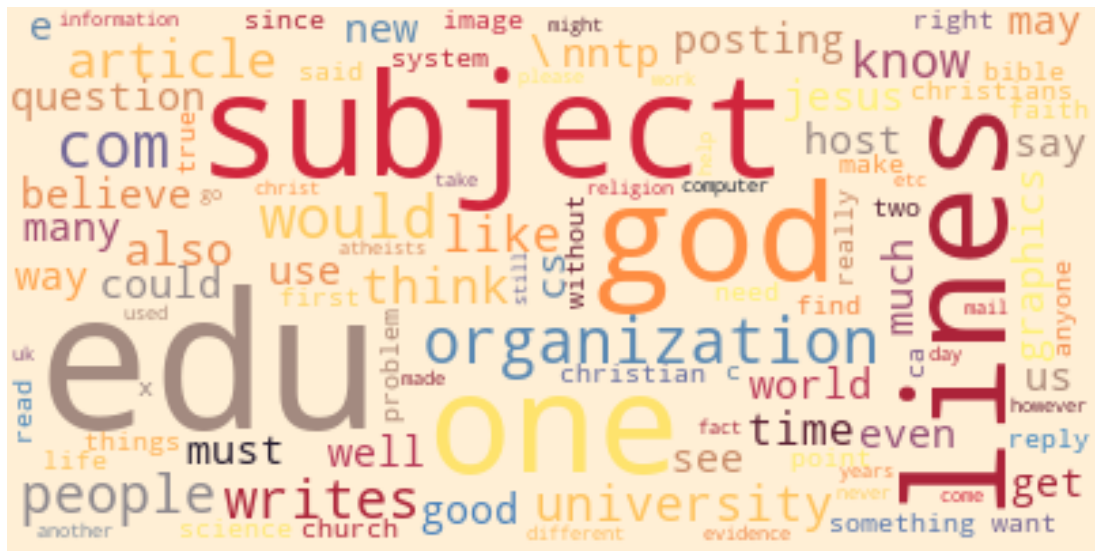

In [51]:
hero.wordcloud(df_train.clean_text, max_words=100,)

In [50]:
NUM_TOP_WORDS = 5
df_train.groupby('target_label')['clean_text'].apply(lambda x: hero.top_words(x)[:NUM_TOP_WORDS])

target_label                        
alt.atheism             edu             1207
                        \                784
                        god              711
                        one              697
                        people           576
comp.graphics           edu             1034
                        lines            645
                        subject          625
                        graphics         605
                        organization     575
sci.med                 edu             1388
                        com              853
                        subject          636
                        organization     606
                        lines            592
soc.religion.christian  god             1490
                        edu             1043
                        one              795
                        would            777
                        subject          666
Name: clean_text, dtype: int64

In [79]:
from texthero import stopwords
default_stopwords = stopwords.DEFAULT
custom_stopwords = default_stopwords.union(set(["subject","com","edu","\\","e","c","x"]))
df_train['clean_text'] = hero.remove_stopwords(df_train['clean_text'], custom_stopwords)

In [82]:
NUM_TOP_WORDS = 10
df_train.groupby('target_label')['clean_text'].apply(lambda x: hero.top_words(x)[:NUM_TOP_WORDS])

target_label                        
alt.atheism             god              711
                        one              697
                        people           576
                        writes           563
                        lines            511
                        would            503
                        organization     456
                        article          414
                        think            391
                        keith            328
comp.graphics           lines            645
                        graphics         605
                        organization     575
                        image            554
                        university       359
                        posting          307
                        file             302
                        would            296
                        host             290
                        jpeg             280
sci.med                 organization     606
                  

# II FastText

In [83]:
import fasttext

fastText expects the category first, with the prefix ‘__label__’ before each category, and then the input text, like so,

__label__positive I really enjoyed this restaurant. Would love to visit again.

In [85]:
df_train = pd.DataFrame(data= np.c_[twenty_train['data'], twenty_train['target']], columns= ['text','target'])
df_test = pd.DataFrame(data= np.c_[twenty_test['data'], twenty_test['target']], columns= ['text','target'])

In [86]:
df_train['clean_text'] = hero.clean(df_train['text'])
df_test['clean_text'] = hero.clean(df_test['text'])
from texthero import stopwords
default_stopwords = stopwords.DEFAULT
custom_stopwords = default_stopwords.union(set(["subject","com","edu","\\","e","c","x"]))

df_train['clean_text'] = hero.remove_stopwords(df_train['clean_text'], custom_stopwords)
df_test['clean_text'] = hero.remove_stopwords(df_test['clean_text'], custom_stopwords)

In [87]:
# je remplace ma colonne target numérique par son label 
df_train = df_train.astype({'target': 'int64'})
df_train['target'] = df_train.target.apply(lambda x :twenty_train.target_names[x])
df_train["target"] = df_train[["target"]].apply(lambda x: '__label__' + x)

# je fais pareil pour le jeu de test
df_test = df_test.astype({'target': 'int64'})
df_test['target'] = df_test.target.apply(lambda x :twenty_test.target_names[x])
df_test["target"] = df_test[["target"]].apply(lambda x: '__label__' + x)

In [88]:
df_train.head()

,text,target,clean_text
0,From: sd345@city.ac.uk (Michael Collier)\nSubj...,__label__comp.graphics,sd345 city ac uk michael collier converting i...
1,From: ani@ms.uky.edu (Aniruddha B. Deglurkar)\...,__label__comp.graphics,ani ms uky aniruddha b deglurkar help splitt...
2,From: djohnson@cs.ucsd.edu (Darin Johnson)\nSu...,__label__soc.religion.christian,djohnson cs ucsd darin johnson harrassed wor...
3,From: s0612596@let.rug.nl (M.M. Zwart)\nSubjec...,__label__soc.religion.christian,s0612596 let rug nl zwart catholic church pol...
4,From: stanly@grok11.columbiasc.ncr.com (stanly...,__label__soc.religion.christian,stanly grok11 columbiasc ncr stanly elder br...


In [89]:
# Saving the CSV file as a text file to train/test the classifier
import csv
df_train[['target', 'clean_text']].to_csv('train.txt', index = False, sep = ' ', header = None,quoting = csv.QUOTE_NONE, quotechar = "", escapechar = " ")
df_test[['target', 'clean_text']].to_csv('test.txt', index = False, sep = ' ', header = None,quoting = csv.QUOTE_NONE, quotechar = "", escapechar = " ")

In [94]:
model = fasttext.train_supervised('train.txt', wordNgrams = 2)

Read 0M words
Number of words:  32314
Number of labels: 4
Progress: 100.0% words/sec/thread:  312760 lr:  0.000000 avg.loss:  1.387220 ETA:   0h 0m 0s


In [95]:
#1502 lines, precision 0.40, recall 0.40
model.test('test.txt')  

(1502, 0.6198402130492676, 0.6198402130492676)